# Experience replay $Q$-learning on cartpole
Below, we run the experience replay $Q$-learning algorithm on the cartpole example. 

* [You can read about the cartpole problem here.](cartpole.ipynb)
* [You can read about experience replay $Q$-learning here.](replay_q_notebook.ipynb)
* [You can see the pure code for experience replay $Q$-learning on cartpole here.](./cartpole/replay_q_on_cartpole.py)

## Summary of the algorithm
We build a (deep) network to represent $Q(s,a)$= `network(state)` 

```
network = keras.Sequential([
        keras.layers.Dense(30, input_dim=n_s, activation='relu'),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dense(n_a)])
        
self.network.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
```
and initiate an empty `memory=[]`.

Then, we iteratively improve the network. In each iteration of the algorithm, we do the following
* i. We rollout the environment to collect data for experience replay $Q$-learning by following these steps:
    * i.a. We observe the `state` $s$ and select the `action` $a$ according to
    
    ```
    if np.random.random() <= epsilon:
        selected_action = env.action_space.sample()

    else:
        selected_action = np.argmax(self.network(state))
    ```
    
 
    * i.b. We derive the environment using $a$ and observe the `reward` $r$, the next state $s^{\prime}$, and the boolean $done$ (which is `True` if the episode has ended and `False` otherwise).
    * i.c. We add $s,\:a,\:r,\:s^{\prime},\:done$ to `memory`.
    * i.d. We continue from i.a. until the episode ends.
* ii. We improve the $Q$ network
    * ii.a. We sample a batch from `memory`. Let `states`, `actions`, `rewards`, `next_states`, `dones` denote the sampled batch.
    
    `batch = random.sample(self.memory, min(len(self.memory), batch_size))`
    
    `states, actions, rewards, new_states, dones = list(map(lambda i: [j[i] for j in batch], range(5)))`
    
    * ii.b. We supply `states`, `actions`, `rewards`, `next_states`, `dones` to the network and optimize the parameters of the network.

## Running on google colab
If you want to run on google colab, go ahead and run the following cell. If you want to run on your computer, skip this cell and start from Importing libraries.

In [1]:
!git clone https://github.com/FarnazAdib/Crash_course_on_RL.git
%cd Crash_course_on_RL
!pip install .

Cloning into 'Crash_course_on_RL'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 164 (delta 92), reused 147 (delta 75), pack-reused 0
Receiving objects: 100% (164/164), 367.57 KiB | 17.50 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/Crash_course_on_RL
Processing /content/Crash_course_on_RL
  Created wheel for Reinforcement-Learning-for-Control: filename=Reinforcement_Learning_for_Control-0.0.1-cp36-none-any.whl size=3832 sha256=2c9aa88606496da577a4dbae2777a4cae4597c52b88bca526285d53a1616365c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ub6tgf96/wheels/9b/1d/4f/f6799e86f243362b1f3fb259778269457c7c763ccf94aab885
Successfully built Reinforcement-Learning-for-Control


## Importing libraries
We start coding by importing the required libraries. If you get an error, you have possibly forgotten to change the kernel. See [Prepare a virtual environment](Preparation.ipynb).

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from collections import deque
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from cartpole.dynamics import CartPole

## Saving directories
Next, we set up some paths to write data and capture some videos for future investigation.

In [3]:
STORE_PATH = '/tmp/cartpole_exp1/Q_replay'
data_path = STORE_PATH + f"/data_{dt.datetime.now().strftime('%d%m%Y%H%M')}"
agent_path = STORE_PATH + f"/agent_{dt.datetime.now().strftime('%d%m%Y%H%M')}"
train_writer = tf.summary.create_file_writer(data_path)

## Making the environment
We select the random seed and make the cartpole environment.


In [4]:
Rand_Seed = 1
env_par = {
    'Rand_Seed': Rand_Seed,
    'STORE_PATH': STORE_PATH,
    'monitor': False,
    'threshold': 195.0
}
Rand_Seed = 1
CP = CartPole(env_par)


## Making the experience replay $Q$-learning agent
We define the $Q$ learning class. This class receives a dictionary with the following entries:
* `hidden_size`: Number of nodes in the layers.
* `GAMMA`: forgetting factor in the total cost. It should be in $[0\:1]$.
* `num_episodes`: The maximum number of episodes to run.
* `batch_size`: The memory length
* `epsilon`: The probability of exploration. It should be in $(0\:1)$.
* `epsilon_decay`: The decay rate of epsilon.
* `epsilon_min`: The minimum value of epsilon.
* `learning_rate_adam`: The learning rate for adam optimization.
* `adam_eps`: The epsilon in adam optimization.




In [5]:
class Q:
    def __init__(self, hparams, epsilon_min=0.01, epsilon_decay=0.995):
        self.hparams = hparams
        np.random.seed(hparams['Rand_Seed'])
        tf.random.set_seed(hparams['Rand_Seed'])
        random.seed(hparams['Rand_Seed'])
        self.memory = deque(maxlen=100000)
        self.epsilon = hparams['epsilon']
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # The Q network
        self.network = keras.Sequential([
            keras.layers.Dense(self.hparams['hidden_size'], input_dim=self.hparams['num_state'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['hidden_size'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['hidden_size'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['num_actions'], dtype='float64')
        ])

        # The cost function for the Q network
        self.network.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(
            epsilon=self.hparams['adam_eps'], learning_rate=self.hparams['learning_rate_adam']))

    def get_action(self, state, env):
        state = self._process_state(state)

        # Exploration
        if np.random.random() <= self.epsilon:
            selected_action = env.action_space.sample()

        # Exploitation
        else:
            selected_action = np.argmax(self.network(state))
        return selected_action

    def remember(self, state, action, reward, next_state, done):
        # Adding data to the history batch
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        # Sampling the history batch
        batch = random.sample(self.memory, min(len(self.memory), batch_size))
        states, actions, rewards, new_states, dones = list(map(lambda i: [j[i] for j in batch], range(5)))
        loss = self.update_network(states, actions, rewards, new_states, dones)
        
        # decreasing the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

    def update_network(self, states, actions, rewards, next_states, dones):
        eps_length = len(states)
        states = np.vstack(states)
        q_target = self.network(states).numpy()
        for i in range(eps_length):
            if dones[i]:
                q_target[i, actions[i]] = rewards[i]
            else:
                next_state = self._process_state(next_states[i])
                q_target[i, actions[i]] = rewards[i] + \
                                        self.hparams['GAMMA'] * tf.math.reduce_max(self.network(next_state)).numpy()
        loss = self.network.train_on_batch(states, q_target)
        return loss

    def _process_state(self, state):
        return state.reshape([1, self.hparams['num_state']])



The function `remember` adds the data point `state`, `action`, `reward`, `next_state`, `done` to the memeory history. In the experience replay, the history is sampled and the parameters of the network are updated using the sampled data. This is done by the function `replay(self, batch_size)`.

Now that we have defined the experience replay $Q$-learning algorithm, it is enough to build an object and to iterate. You can change the following hyper parameters if you like

* `hidden_size`: Number of nodes in the layers.
* `GAMMA`: forgetting factor in the total cost. It should be in $[0\:1]$.
* `num_episodes`: The maximum number of episodes to run.
* `batch_size`: The memory length
* `epsilon`: The probability of exploration. It should be in $(0\:1)$.
* `epsilon_decay`: The decay rate of epsilon.
* `epsilon_min`: The minimum value of epsilon.
* `learning_rate_adam`: The learning rate for adam optimization.
* `adam_eps`: The epsilon in adam optimization.


In [6]:
agent_par = {
    'num_state': CP.env.observation_space.shape[0],
    'num_actions': CP.env.action_space.n,
    'Rand_Seed': Rand_Seed,
    'hidden_size': 30,
    'GAMMA': 1.0,
    'num_episodes': 5000,
    'batch_size': 200,
    'epsilon': 0.1,  # exploration rate
    'epsilon_decay': 0.995,
    'epsilon_min': 0.01,
    'learning_rate_adam': 0.01,
    'adam_eps': 0.1
}
policy = Q(agent_par)


## Start learning
Now, we start the learning loop. The learning loop iterates for a maximum of number of `num_episodes`. In each iteration
* The agent derives the environment for one episode to collect data for experience replay $Q$-learning. The parameter `remember` is `Ture`. So, the data is saved in the `agent.memory`
* We update the $Q$-network using experience replay.
* We check if the problem is solved.
* We write the data.
At the end of the learning loop, we close the environment.

In [7]:
# Running the algorithm for a maximum number of iteration until it is solved
tot_rews = []
mean_100ep = 0.0
for episode in range(agent_par['num_episodes']):

    # Do one rollout. When remember=True, data is saved in policy.memory
    _, _, rewards, _, _ = CP.one_rollout(policy, remember=True)

    # Update the network using experience replay
    loss = policy.replay(agent_par['batch_size'])

    # Check if the problem is solved
    if episode > 100:
        mean_100ep = np.mean(tot_rews[-101:-1])

    tot_reward = sum(rewards)
    tot_rews.append(tot_reward)
    print(f"Episode: {episode}, Reward: {tot_reward}, Mean of 100 cons episodes: {mean_100ep}")
    if mean_100ep > env_par['threshold']:
        print(f"Problem solved after {episode} Episode with the mean reward {mean_100ep} over the last 100 episodes ")
        policy.network.save(agent_path)
        break

    # Save data
    with train_writer.as_default():
        tf.summary.scalar('reward', tot_reward, step=episode)

# Close the environment
CP.env.close()

# Print the summary of the solution
if mean_100ep > env_par['threshold']:
    print(f"\n\nProblem is solved after {episode} Episode with the mean reward {mean_100ep} over the last 100 episodes")


Episode: 0, Reward: 11.0, Mean of 100 cons episodes: 0.0
Episode: 1, Reward: 10.0, Mean of 100 cons episodes: 0.0
Episode: 2, Reward: 11.0, Mean of 100 cons episodes: 0.0
Episode: 3, Reward: 8.0, Mean of 100 cons episodes: 0.0
Episode: 4, Reward: 10.0, Mean of 100 cons episodes: 0.0
Episode: 5, Reward: 9.0, Mean of 100 cons episodes: 0.0
Episode: 6, Reward: 9.0, Mean of 100 cons episodes: 0.0
Episode: 7, Reward: 10.0, Mean of 100 cons episodes: 0.0
Episode: 8, Reward: 10.0, Mean of 100 cons episodes: 0.0
Episode: 9, Reward: 9.0, Mean of 100 cons episodes: 0.0
Episode: 10, Reward: 13.0, Mean of 100 cons episodes: 0.0
Episode: 11, Reward: 8.0, Mean of 100 cons episodes: 0.0
Episode: 12, Reward: 12.0, Mean of 100 cons episodes: 0.0
Episode: 13, Reward: 11.0, Mean of 100 cons episodes: 0.0
Episode: 14, Reward: 9.0, Mean of 100 cons episodes: 0.0
Episode: 15, Reward: 10.0, Mean of 100 cons episodes: 0.0
Episode: 16, Reward: 9.0, Mean of 100 cons episodes: 0.0
Episode: 17, Reward: 10.0, Mean

## Results
It will get around a minute to run the above cell. You will probably get some WARNING\ERROR. Some of these are related to incompatibility between some libraries. Don't panic. The problem will be solved after possibly after 475-500 episodes. The evalution of the rewards vs. iteration is shown for a learning trial of length ~475 iterations is shown below. You can see how the reward is improved as the iteration goes on
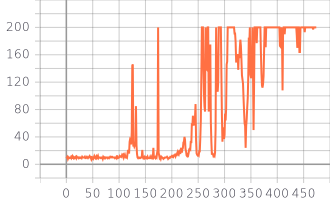

It is a quite good improvement. It is good to know that [the best algorithm](https://gym.openai.com/evaluations/eval_lEi8I8v2QLqEgzBxcvRIaA/) solves this problem after around 211 episodes.